In [1]:
from apiKey import lastFMKey
from apiKey import lastFMSecret

#import needed libraries
import pandas as pd
import matplotlib as plt
import json
import numpy
import requests as req
import pylast
import time
import iso3166 as iso
import csv

# print(lastFMKey)
# print(lastFMSecret)

ModuleNotFoundError: No module named 'pylast'

#### Declare variables

In [4]:
country = iso.Country
country

NameError: name 'iso' is not defined

In [15]:
countryCsv = "../Output/countries.csv"
counrtyTopArtistCSV = "../Output/countriesTopArtist.csv"
countriesArtistNotFound = "../Output/countriesArtistNotFound.txt"
artistCSV = "../Output/artist.csv"
jsonFile = "../Output/lastFMCountryArtist.json"


#### Def methods for calling and displaying

In [21]:
def lastfm_get(payload):
    # define headers and URL
    headers = {'user-agent': 'bootcamp'}
    url = 'https://ws.audioscrobbler.com/2.0/'

    # Add API key and format to the payload
    payload['api_key'] = lastFMKey
    payload['format'] = 'json'

    response = req.get(url, headers=headers, params=payload)
    return response

In [22]:
def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)

#### Country collection and export to csv

In [ ]:
#parameters for writing countries to csv
params = open(countryCsv, "w")
countries = iso.countries_by_name
countries.pop('UNITED STATES OF AMERICA', None)

#after data checking the following are not in lastfm in the iso3166 standard as the documentation states
countries["UNITED STATES"] = ("UNITED STATES")
countries["UNITED KINGDOM"] = ("UNITED KINGDOM")
#countries #sanity check

#write countries to csv
csvwriter = csv.writer(params)

for country in countries.items():
    csvwriter.writerow(country)

#### Loop through countries and collect top 50 per country

#### Get list of top artist per country and add to dataframe

In [ ]:
iterator = 0
header = True
mode = 'w'

for country in countries:
    
    iterator += 1
    if (iterator > 1):
        header = False
        mode = 'a'
        
    #lastFm call to get top artists for each country
    responseTopArt = lastfm_get({
        'method':'geo.getTopArtists',
        'country':country,
        'limit':'50'
    })
    r = responseTopArt.json()
    
    try:
        #print(f"Looking to top artists for {country}.  Mode: {mode}. Iterator:{iterator}")
        artistDF = pd.json_normalize(r,[["topartists","artist"]])
        artistDF['country'] = country
              
        with open(counrtyTopArtistCSV, mode) as f:
            artistDF.to_csv(f, header=header)
            
    except:
        print(f"No artists found for {country}")
    #throttle api calls by 1 sec.  
    time.sleep(1)
    
# jprint(r.json())

#### Get Artist information and save to CSV.

In [242]:
iterator = 0
header = True
mode = 'w'

artistDF = pd.read_csv(counrtyTopArtistCSV)
artistDedupeDF = artistDF['name'].drop_duplicates()  #cleaning duplicate artists

for artist in artistDedupeDF:
    
    iterator += 1
    if (iterator > 1):
        header = False
        mode = 'a'
    
    #call lastfm to get data
    responseArtist = lastfm_get({
        'method':'artist.getInfo',
        'artist': artist
    })

    a = responseArtist.json()
    
    #audit logging
    print(f"Looking to top artists for {artist}.  Mode: {mode}. Iterator:{iterator}")

    #takes json and flattens into the needed columns and converts to dataframe
    artistDF = pd.json_normalize(a['artist'])

    #explodes tags.tag - takes the json value in the column and breaks them into multiple records that represent each value in the json
    explodeTags = artistDF[["name","stats.listeners","stats.playcount","streamable","tags.tag"]].explode("tags.tag")

    finalArtDF = (pd.concat({i: pd.json_normalize(x) for i, x in explodeTags.pop('tags.tag').items()})
               .reset_index(level=1, drop=True)
               .join(explodeTags,lsuffix="_genre")
               .reset_index(drop=True)
          )
    
    #cleaning duplicate artists
    finalArtDF.drop_duplicates()  
    
    #write dataset to csv
    with open(artistCSV, mode) as f:
        finalArtDF.to_csv(f, header=header)

# # data = json.loads()
# jprint(r.json())

Looking to top artists for The xx.  Mode: w. Iterator:1
Looking to top artists for The Beatles.  Mode: a. Iterator:2
Looking to top artists for Radiohead.  Mode: a. Iterator:3
Looking to top artists for Lana Del Rey.  Mode: a. Iterator:4
Looking to top artists for Pink Floyd.  Mode: a. Iterator:5
Looking to top artists for Metallica.  Mode: a. Iterator:6
Looking to top artists for Drake.  Mode: a. Iterator:7
Looking to top artists for Nirvana.  Mode: a. Iterator:8
Looking to top artists for Katy Perry.  Mode: a. Iterator:9
Looking to top artists for Kendrick Lamar.  Mode: a. Iterator:10
Looking to top artists for Led Zeppelin.  Mode: a. Iterator:11
Looking to top artists for blink-182.  Mode: a. Iterator:12
Looking to top artists for Depeche Mode.  Mode: a. Iterator:13
Looking to top artists for The Rolling Stones.  Mode: a. Iterator:14
Looking to top artists for Oasis.  Mode: a. Iterator:15
Looking to top artists for Michael Jackson.  Mode: a. Iterator:16
Looking to top artists for Ma

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy
import csv
from scipy import stats

TopArtistCSV = '../Output/countriesTopArtist.csv'

#sample csv read
artistCSVDF = pd.read_csv(TopArtistCSV)
artistCSVDF

,name,listeners,mbid,country
0,The xx,2090127,c5c2ea1c-4bde-4f4d-bd0b-47b200bf99d6,AFGHANISTAN
1,The Beatles,4082721,b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d,AFGHANISTAN
2,Radiohead,5094619,a74b1b7f-71a5-4011-9441-d0b5e4122711,AFGHANISTAN
3,Lana Del Rey,2352583,b7539c32-53e7-4908-bda3-81449c367da6,AFGHANISTAN
4,Pink Floyd,3399905,83d91898-7763-47d7-b03b-b92132375c47,AFGHANISTAN
...,...,...,...,...
9561,Eminem,4966239,b95ce3ff-3d05-4e87-9e01-c97b66af13d4,UNITED KINGDOM
9562,Kings of Leon,3652328,6ffb8ea9-2370-44d8-b678-e9237bbd347b,UNITED KINGDOM
9563,Lana Del Rey,2352583,b7539c32-53e7-4908-bda3-81449c367da6,UNITED KINGDOM
9564,Ariana Grande,1681258,f4fdbb4c-e4b7-47a0-b83b-d91bbfcfa387,UNITED KINGDOM


In [3]:
# Importing country GDP data from https://worldpopulationreview.com/countries/countries-by-gdp

GDP_csv = '../Input/GDP.csv'
GDP_df = pd.read_csv(GDP_csv)
GDP_df

,rank,country,imfGDP,unGDP,gdpPerCapita,pop
0,1,United States,2.219810e+13,1.862450e+13,66678.0263,332915.073
1,2,China,1.546810e+13,1.121830e+13,10710.3777,1444216.107
2,3,Japan,5.495420e+12,4.936210e+12,43596.8659,126050.804
3,4,Germany,4.157120e+12,3.477800e+12,49548.2308,83900.473
4,5,India,3.257720e+12,2.259640e+12,2337.9495,1393409.038
...,...,...,...,...,...,...
206,207,Pakistan,0.000000e+00,2.825060e+11,1254.4675,225199.937
207,208,Anguilla,0.000000e+00,3.375205e+08,22327.2124,15.117
208,209,Sudan,0.000000e+00,8.288740e+10,1845.6600,44909.353
209,210,Syria,0.000000e+00,2.216308e+10,1212.7072,18275.702


In [89]:


# 196 countries in artist csv
# 211 countries in GDP data

# artistCSVDF['country'] 
GDP_df['country'] = GDP_df['country'].str.title()
artistCSVDF['country'] = artistCSVDF['country'].str.title()

GDP_artist_df = artistCSVDF.merge(GDP_df, how='left')

# Removing rows where gdpPerCapita equals NaN
GDP_artist_df = GDP_artist_df[pd.to_numeric(GDP_artist_df['gdpPerCapita'],errors='coerce').notna()]

print(len())
GDP_artist_df

8115


,name,listeners,mbid,country,rank,imfGDP,unGDP,gdpPerCapita,pop
0,The xx,2090127,c5c2ea1c-4bde-4f4d-bd0b-47b200bf99d6,Afghanistan,116.0,2.068200e+10,2.023506e+10,519.1861,39835.428
1,The Beatles,4082721,b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d,Afghanistan,116.0,2.068200e+10,2.023506e+10,519.1861,39835.428
2,Radiohead,5094619,a74b1b7f-71a5-4011-9441-d0b5e4122711,Afghanistan,116.0,2.068200e+10,2.023506e+10,519.1861,39835.428
3,Lana Del Rey,2352583,b7539c32-53e7-4908-bda3-81449c367da6,Afghanistan,116.0,2.068200e+10,2.023506e+10,519.1861,39835.428
4,Pink Floyd,3399905,83d91898-7763-47d7-b03b-b92132375c47,Afghanistan,116.0,2.068200e+10,2.023506e+10,519.1861,39835.428
...,...,...,...,...,...,...,...,...,...
9561,Eminem,4966239,b95ce3ff-3d05-4e87-9e01-c97b66af13d4,United Kingdom,6.0,2.927080e+12,2.647900e+12,42914.5839,68207.116
9562,Kings of Leon,3652328,6ffb8ea9-2370-44d8-b678-e9237bbd347b,United Kingdom,6.0,2.927080e+12,2.647900e+12,42914.5839,68207.116
9563,Lana Del Rey,2352583,b7539c32-53e7-4908-bda3-81449c367da6,United Kingdom,6.0,2.927080e+12,2.647900e+12,42914.5839,68207.116
9564,Ariana Grande,1681258,f4fdbb4c-e4b7-47a0-b83b-d91bbfcfa387,United Kingdom,6.0,2.927080e+12,2.647900e+12,42914.5839,68207.116


In [84]:
grouped_GDP_Artist = GDP_artist_df.groupby('country')

GDP_per_capita = grouped_GDP_Artist['gdpPerCapita'].mean()
listeners_per_country = grouped_GDP_Artist['listeners'].sum()

# GDP_per_capita
# listeners_per_country



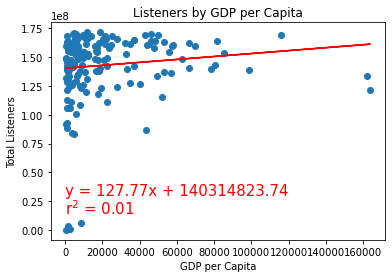

In [88]:
# Generating scatter plot
plt.scatter(GDP_per_capita, listeners_per_country)

plt.xlabel('GDP per Capita')
plt.ylabel('Total Listeners')
plt.title('Listeners by GDP per Capita')
# plt.yticks(labels=)


plt.yscale(value='linear')


# Running linear regression
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(GDP_per_capita, listeners_per_country)

regress_values = GDP_per_capita * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept, 2))

# Linear Regression of the GDP per capita and number of listeners
r_sq = rvalue * rvalue
r_sq_text = f'r$^2$ = {round(r_sq,2)}'

plt.plot(GDP_per_capita, regress_values, 'r-')
plt.annotate(line_eq,(20,30000000),fontsize=15, color='red')
plt.annotate(r_sq_text,(20,14000000),fontsize=15, color='red')


plt.show()